<a href="https://colab.research.google.com/github/Randhir123/quant/blob/main/Time_series_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import gc
import os
import random
import copy
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

We'll analyze the closing price of AAPL stocks.

[*********************100%%**********************]  1 of 1 completed


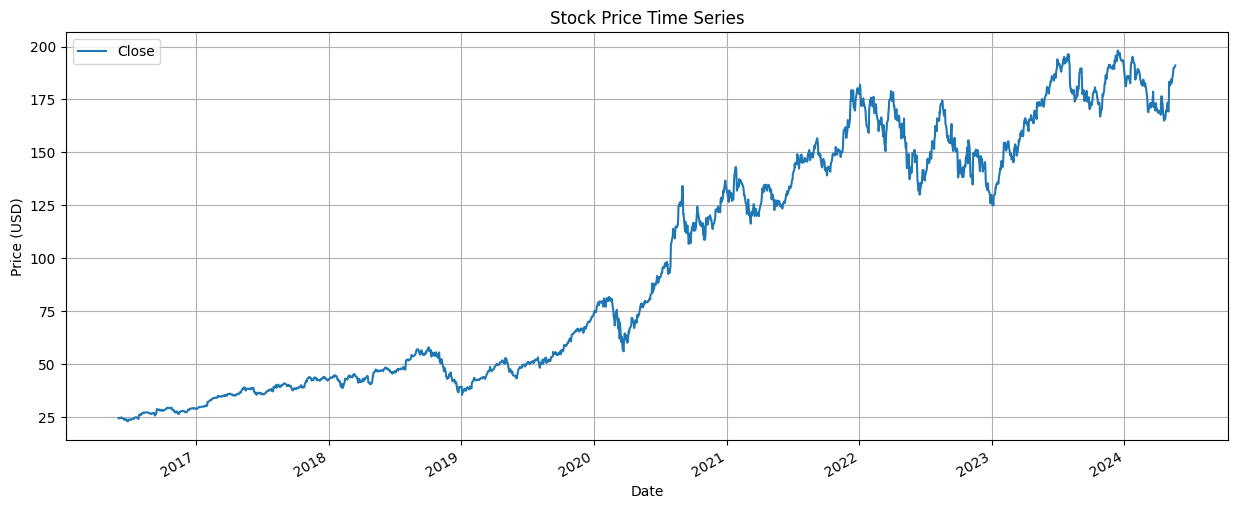

In [24]:
# Load stock price data
df = yf.download("AAPL", start="2016-06-01", end="2024-05-21")
df=df.drop(columns=['Open','High','Low','Volume', 'Adj Close'])

# Plot the original time series
df.plot(figsize=(15,6))
plt.title('Stock Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

Let's check the summary statistics.

In [25]:
# Summary statistics
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
             Close
count  2006.000000
mean     98.450604
std      56.856812
min      23.010000
25%      43.598126
50%      80.936249
75%     150.799999
max     198.110001


Usually univariate time series analysis is done on a stationary series, so first off we'll check for stationarity.

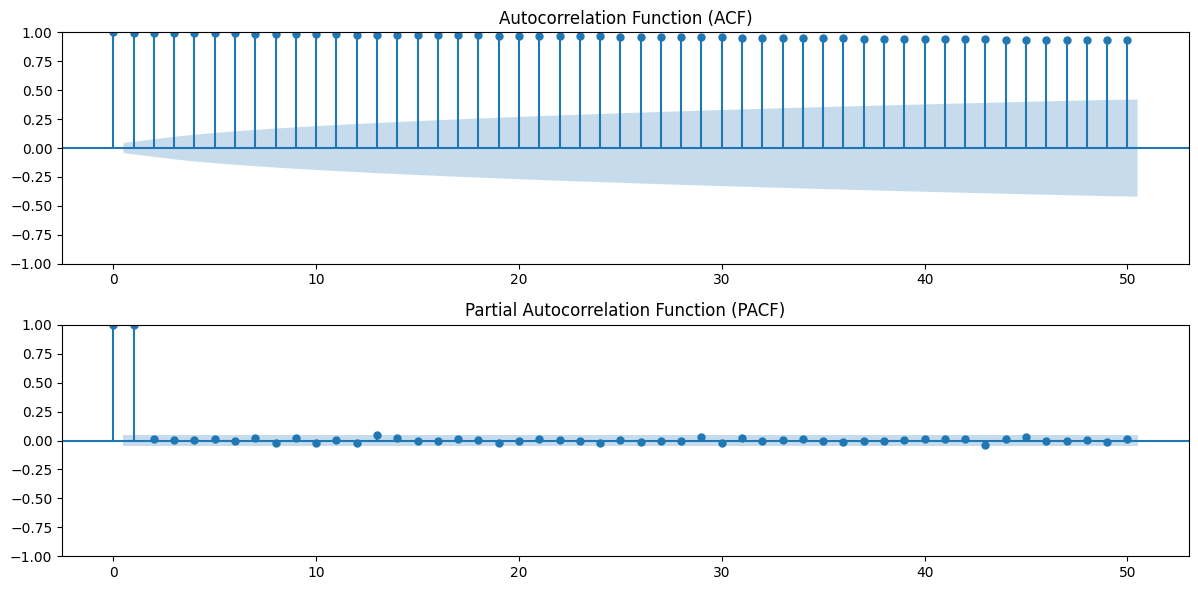

In [27]:
# ACF and PACF plots for persistence

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df, ax=plt.gca(), lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.subplot(2, 1, 2)
plot_pacf(df, ax=plt.gca(), lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [28]:
# Augmented Dickey-Fuller (ADF) test for stationarity
adf_result = adfuller(df)
print("\nADF Test Results:")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")


ADF Test Results:
ADF Statistic: -0.4605141594598856
p-value: 0.8994943104821944
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156


The ADF statistic is larger than the critical values at different level of significance. We cannot reject the null hypothesis of non-stationarity.

Let's use the logarithm of the original series.

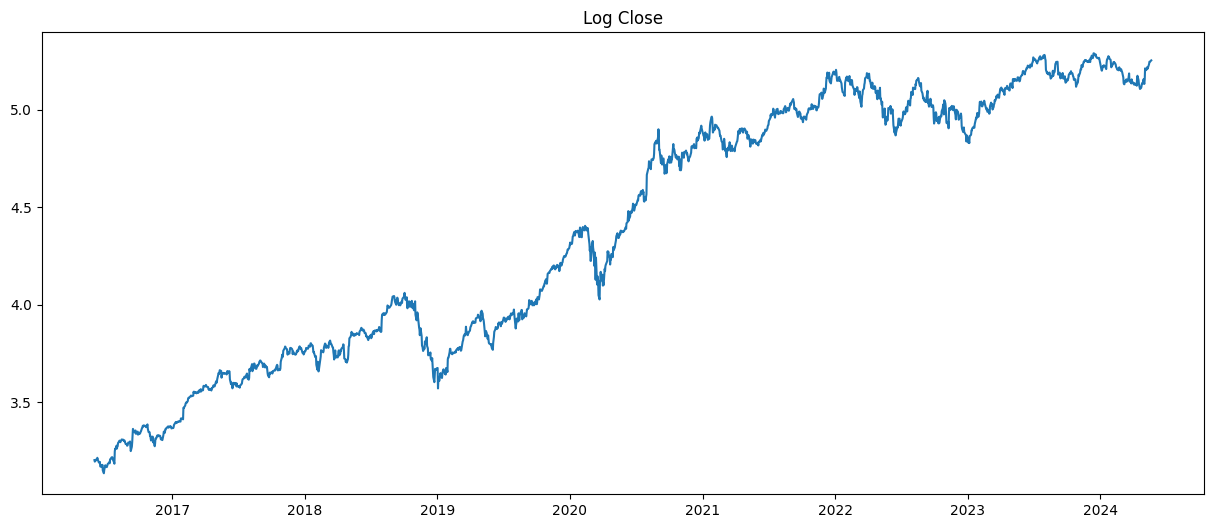

In [29]:
df_log = pd.DataFrame(np.log(df['Close']),index=df.index)
plt.figure(figsize=(15,6))
plt.plot(df_log)
plt.title('Log Close')
plt.show()

In [30]:
# Augmented Dickey-Fuller (ADF) test for stationarity
adf_result = adfuller(df_log)
print("\nADF Test Results:")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")


ADF Test Results:
ADF Statistic: -1.2776245051912318
p-value: 0.6393459548923692
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156


The log of the series is also non-stationary.

##Differencing

Let's now try to difference the series or the log of the series.

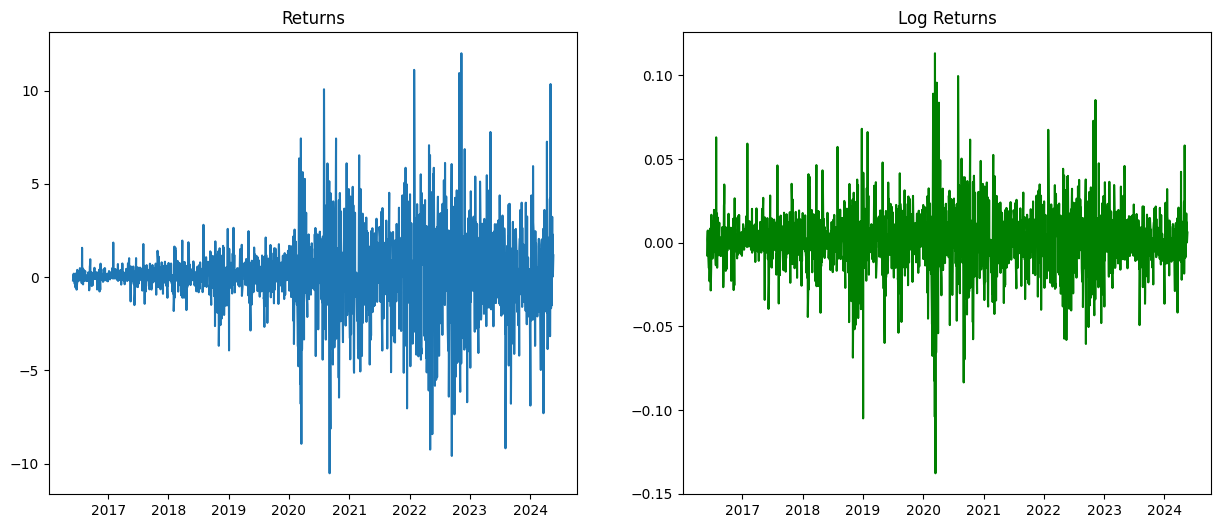

In [35]:
df['Returns']=df['Close']-df['Close'].shift(1)
df_log['Log_Returns']=df_log['Close']-df_log['Close'].shift(1)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(df['Returns'])
plt.title('Returns')
plt.subplot(1,2,2)
plt.plot(df_log['Log_Returns'],'g-')
plt.title('Log Returns')
plt.show()

Let's check both of our new series through the ADF test.

In [38]:
adf_result_returns = adfuller(df['Returns'].dropna())
print("\nADF Test Results for Returns:")
print("ADF Statistic:", adf_result_returns[0])
print("p-value:", adf_result_returns[1])
print("Critical Values:")
for key, value in adf_result_returns[4].items():
    print(f"\t{key}: {value}")


adf_result_log_returns = adfuller(df_log['Log_Returns'].dropna())
print("\nADF Test Results for Log_Returns:")
print("ADF Statistic:", adf_result_log_returns[0])
print("p-value:", adf_result_log_returns[1])
print("Critical Values:")
for key, value in adf_result_log_returns[4].items():
    print(f"\t{key}: {value}")


ADF Test Results for Returns:
ADF Statistic: -14.606628895391774
p-value: 4.084929825598094e-27
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156

ADF Test Results for Log_Returns:
ADF Statistic: -14.068038529279898
p-value: 2.974401974504954e-26
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156


We have stationary series that we can now work with for our forecasts.

##Fractional Differencing
Next, let's use an approach called fractional differencing. Using fractionally differenced variables as dependent variables or features for time series modelling could improve predictive performance in many cases because the time series is allowed to retain more memory while still being stationary.

In [39]:
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1)
    return w
def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot(figsize=(15,6))
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    #plt.grid(False)
    plt.show()
def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients

    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]

In [45]:
df['fractional'] = ts_differencing(df['Close'],0.9,20)
df_log['fractional'] = ts_differencing(df_log['Close'],0.9,20)

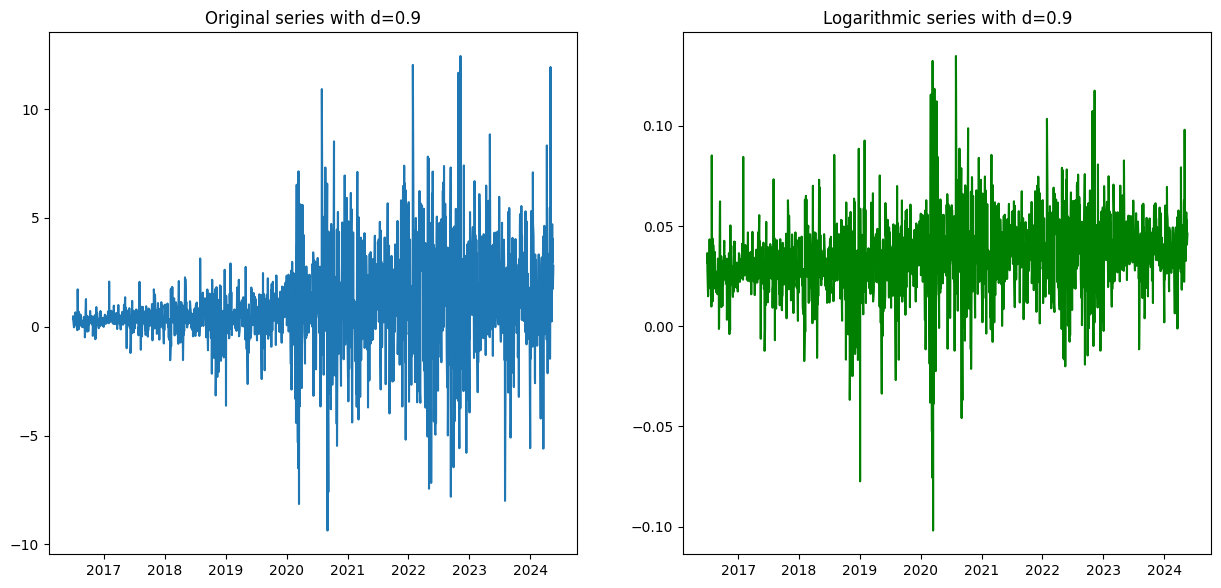

In [46]:
differences=[0.9]
fig, axs = plt.subplots(len(differences),2,figsize=(15,6))
for i in range(0,len(differences)):
    axs[0].plot(df['fractional'])
    axs[0].set_title('Original series with d='+str(differences[i]))
    axs[1].plot(df_log['fractional'],'g-')
    axs[1].set_title('Logarithmic series with d='+str(differences[i]))
    plt.subplots_adjust(bottom=0.01) #increasing space between plots for aestethics

Let's check both of our new series through the ADF test.

In [47]:
adf_result_fractional = adfuller(df['fractional'].dropna())
print("\nADF Test Results for Fractional:")
print("ADF Statistic:", adf_result_fractional[0])
print("p-value:", adf_result_fractional[1])
print("Critical Values:")
for key, value in adf_result_fractional[4].items():
    print(f"\t{key}: {value}")


adf_result_log_fractional = adfuller(df_log['fractional'].dropna())
print("\nADF Test Results for Fractional:")
print("ADF Statistic:", adf_result_log_fractional[0])
print("p-value:", adf_result_log_fractional[1])
print("Critical Values:")
for key, value in adf_result_log_fractional[4].items():
    print(f"\t{key}: {value}")


ADF Test Results for Fractional:
ADF Statistic: -7.401482908989515
p-value: 7.534908468166931e-11
Critical Values:
	1%: -3.4336771595431106
	5%: -2.863009746829746
	10%: -2.5675524325901415

ADF Test Results for Fractional:
ADF Statistic: -6.328209788530858
p-value: 2.9503178659131254e-08
Critical Values:
	1%: -3.4336788532475775
	5%: -2.8630104945933974
	10%: -2.567552830738709


After fractional differencing, the series is stationary.